In [1]:
import geopandas as gpd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import time

from sklearn.metrics import mutual_info_score
from scipy.stats import spearmanr
import pytensor.tensor as pt

## Distributions for volume and number of occupants

In [2]:
complete_gdf = gpd.read_file("../Test data/buildings_with_occupants.geojson")
    
# Extract residential buildings
residential_gdf = complete_gdf[complete_gdf['citygml_function'] == '31001_1000'].copy()

In [3]:
# Function to create discrete distribution
def create_discrete_distribution(data, column_name, n_bins=20, method='auto'):
    """
    Create a discrete distribution from continuous data by binning.
    
    Parameters:
    -----------
    data : array-like
        The data to bin
    column_name : str
        Name of the column for labeling
    n_bins : int or str
        Number of bins or binning method ('auto', 'fd', 'sturges', 'sqrt', etc.)
    method : str
        Binning method: 'auto', 'equal_width', 'equal_frequency'
    
    Returns:
    --------
    pd.DataFrame : DataFrame with bin edges, midpoints, counts, and probabilities
    """
    # Remove NaN values
    clean_data = data[np.isfinite(data)].values
    
    if len(clean_data) == 0:
        print(f"No valid data for {column_name}")
        return None
    
    print(f"\n{'='*60}")
    print(f"Creating Discrete Distribution for: {column_name}")
    print(f"{'='*60}")
    print(f"Original data size: {len(clean_data)}")
    print(f"Min: {clean_data.min():.4f}")
    print(f"Max: {clean_data.max():.4f}")
    print(f"Mean: {clean_data.mean():.4f}")
    print(f"Median: {np.median(clean_data):.4f}")
    
    # Create bins based on method
    if method == 'equal_frequency':
        # Equal frequency (quantile-based) binning
        bin_edges = np.percentile(clean_data, np.linspace(0, 100, n_bins + 1))
        # Remove duplicate edges
        bin_edges = np.unique(bin_edges)
    else:
        # Equal width binning
        if isinstance(n_bins, str):
            counts, bin_edges = np.histogram(clean_data, bins=n_bins)
        else:
            bin_edges = np.linspace(clean_data.min(), clean_data.max(), n_bins + 1)
    
    # Count values in each bin
    counts, _ = np.histogram(clean_data, bins=bin_edges)
    
    # Calculate probabilities
    probabilities = counts / counts.sum()
    
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate bin widths
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    # Create DataFrame
    df = pd.DataFrame({
        'bin_lower': bin_edges[:-1],
        'bin_upper': bin_edges[1:],
        'bin_midpoint': bin_midpoints,
        'bin_width': bin_widths,
        'count': counts,
        'probability': probabilities,
        'cumulative_probability': np.cumsum(probabilities)
    })
    
    # Add bin labels
    df['bin_label'] = df.apply(
        lambda row: f"[{row['bin_lower']:.2f}, {row['bin_upper']:.2f})", 
        axis=1
    )
    
    print(f"\nNumber of bins created: {len(df)}")
    print(f"Total probability: {df['probability'].sum():.6f}")
    
    return df


def plot_discrete_distribution(df, column_name, save_path=None):
    """
    Visualize the discrete distribution.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with binned distribution
    column_name : str
        Name of the column
    save_path : str, optional
        Path to save the figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Probability mass function (PMF)
    ax1 = axes[0, 0]
    ax1.bar(df['bin_midpoint'], df['probability'], 
            width=df['bin_width'] * 0.9, 
            alpha=0.7, color='steelblue', edgecolor='black')
    ax1.set_xlabel(column_name, fontsize=12)
    ax1.set_ylabel('Probability', fontsize=12)
    ax1.set_title(f'Probability Mass Function (PMF)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Cumulative distribution function (CDF)
    ax2 = axes[0, 1]
    ax2.plot(df['bin_midpoint'], df['cumulative_probability'], 
             marker='o', linewidth=2, markersize=6, color='darkgreen')
    ax2.set_xlabel(column_name, fontsize=12)
    ax2.set_ylabel('Cumulative Probability', fontsize=12)
    ax2.set_title(f'Cumulative Distribution Function (CDF)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.05])
    
    # 3. Count histogram
    ax3 = axes[1, 0]
    ax3.bar(df['bin_midpoint'], df['count'], 
            width=df['bin_width'] * 0.9, 
            alpha=0.7, color='coral', edgecolor='black')
    ax3.set_xlabel(column_name, fontsize=12)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_title(f'Frequency Distribution', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Summary statistics table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate statistics from the discrete distribution
    mean_discrete = np.sum(df['bin_midpoint'] * df['probability'])
    variance_discrete = np.sum((df['bin_midpoint'] - mean_discrete)**2 * df['probability'])
    std_discrete = np.sqrt(variance_discrete)
    
    # Find mode (bin with highest probability)
    mode_idx = df['probability'].idxmax()
    mode_bin = df.loc[mode_idx, 'bin_label']
    
    # Find median (50th percentile)
    median_idx = (df['cumulative_probability'] - 0.5).abs().idxmin()
    median_approx = df.loc[median_idx, 'bin_midpoint']
    
    stats_text = f"""
    Discrete Distribution Statistics:
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    Number of bins:        {len(df)}
    
    Mean:                  {mean_discrete:.4f}
    Std Dev:               {std_discrete:.4f}
    Median (approx):       {median_approx:.4f}
    
    Min value:             {df['bin_lower'].min():.4f}
    Max value:             {df['bin_upper'].max():.4f}
    
    Mode bin:              {mode_bin}
    Mode probability:      {df.loc[mode_idx, 'probability']:.4f}
    
    Total count:           {df['count'].sum():.0f}
    """
    
    ax4.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    return fig


def print_distribution_table(df, column_name, top_n=15):
    """
    Print a formatted table of the discrete distribution.
    """
    print(f"\n{'='*80}")
    print(f"Discrete Distribution Table for: {column_name}")
    print(f"{'='*80}")
    print(f"{'Bin Range':<30} {'Midpoint':<12} {'Count':<10} {'Prob':<10} {'Cum Prob':<10}")
    print("-" * 80)
    
    # Show top_n bins with highest probability
    df_sorted = df.nlargest(top_n, 'probability')
    
    for _, row in df_sorted.iterrows():
        print(f"{row['bin_label']:<30} {row['bin_midpoint']:<12.2f} "
              f"{row['count']:<10.0f} {row['probability']:<10.4f} "
              f"{row['cumulative_probability']:<10.4f}")
    
    if len(df) > top_n:
        print(f"\n... and {len(df) - top_n} more bins (showing top {top_n} by probability)")


# Main execution example
if __name__ == "__main__":
    print("Discrete Distribution Creator")
    print("="*80)
    print("\nThis script bins your continuous data into discrete distributions.")
    print("\nExample usage:")
    print("-"*80)
    print("""
    import geopandas as gpd
    
    # Load your data
    residential_gdf = gpd.read_file('your_file.geojson')
    
    # Create discrete distribution for volume (with 30 bins)
    volume_dist = create_discrete_distribution(
        residential_gdf['_volume'], 
        column_name='Building Volume (m³)',
        n_bins=30,
        method='equal_width'
    )
    
    # Create discrete distribution for occupants (with 20 bins)
    occupants_dist = create_discrete_distribution(
        residential_gdf['total_occupants'], 
        column_name='Total Occupants',
        n_bins=20,
        method='equal_width'
    )
    
    # Print distribution tables
    print_distribution_table(volume_dist, 'Building Volume (m³)')
    print_distribution_table(occupants_dist, 'Total Occupants')
    
    # Create visualizations
    plot_discrete_distribution(
        volume_dist, 
        'Building Volume (m³)',
        save_path='/mnt/user-data/outputs/volume_discrete_dist.png'
    )
    
    plot_discrete_distribution(
        occupants_dist, 
        'Total Occupants',
        save_path='/mnt/user-data/outputs/occupants_discrete_dist.png'
    )
    
    # Save distributions to CSV
    volume_dist.to_csv('/mnt/user-data/outputs/volume_distribution.csv', index=False)
    occupants_dist.to_csv('/mnt/user-data/outputs/occupants_distribution.csv', index=False)
    
    print("\\nDistributions saved!")
    
    # You can now sample from these distributions:
    # Sample 100 values from the volume distribution
    samples = np.random.choice(
        volume_dist['bin_midpoint'], 
        size=100, 
        p=volume_dist['probability']
    )
    """)
    print("-"*80)

Discrete Distribution Creator

This script bins your continuous data into discrete distributions.

Example usage:
--------------------------------------------------------------------------------

    import geopandas as gpd

    # Load your data
    residential_gdf = gpd.read_file('your_file.geojson')

    # Create discrete distribution for volume (with 30 bins)
    volume_dist = create_discrete_distribution(
        residential_gdf['_volume'], 
        column_name='Building Volume (m³)',
        n_bins=30,
        method='equal_width'
    )

    # Create discrete distribution for occupants (with 20 bins)
    occupants_dist = create_discrete_distribution(
        residential_gdf['total_occupants'], 
        column_name='Total Occupants',
        n_bins=20,
        method='equal_width'
    )

    # Print distribution tables
    print_distribution_table(volume_dist, 'Building Volume (m³)')
    print_distribution_table(occupants_dist, 'Total Occupants')

    # Create visualizations
    pl

In [4]:
# Only use the buildings within the 2.5th to 97.5th percentile of volume
volume_975th = residential_gdf['_volume'].quantile(0.975)
volume_25th = residential_gdf['_volume'].quantile(0.025)
volume_filtered = residential_gdf[
    (residential_gdf['_volume'] >= volume_25th) &
    (residential_gdf['_volume'] <= volume_975th)
]

In [5]:
# Create discrete distribution for volume (with 30 bins)
volume_dist = create_discrete_distribution(
    volume_filtered['_volume'], 
    column_name='Building Volume (m³)',
    n_bins=10,
    method='equal_width'
)

# Create discrete distribution for occupants (with 20 bins)
occupants_dist = create_discrete_distribution(
    volume_filtered['total_occupants'], 
    column_name='Total Occupants',
    n_bins=10,
    method='equal_width'
)
# Print distribution tables
print_distribution_table(volume_dist, 'Building Volume (m³)')
print_distribution_table(occupants_dist, 'Total Occupants')


Creating Discrete Distribution for: Building Volume (m³)
Original data size: 2733
Min: 339.9949
Max: 11941.9895
Mean: 4289.1914
Median: 3990.7171

Number of bins created: 10
Total probability: 1.000000

Creating Discrete Distribution for: Total Occupants
Original data size: 2733
Min: 1.0000
Max: 68.0000
Mean: 12.6528
Median: 11.0000

Number of bins created: 10
Total probability: 1.000000

Discrete Distribution Table for: Building Volume (m³)
Bin Range                      Midpoint     Count      Prob       Cum Prob  
--------------------------------------------------------------------------------
[2660.39, 3820.59)             3240.49      604        0.2210     0.4673    
[3820.59, 4980.79)             4400.69      558        0.2042     0.6714    
[1500.19, 2660.39)             2080.29      354        0.1295     0.2462    
[4980.79, 6140.99)             5560.89      334        0.1222     0.7936    
[339.99, 1500.19)              920.09       319        0.1167     0.1167    
[6140.99, 

In [ ]:
volume_dist.to_csv('../Output/Data/volume_distribution.csv', index=False)
occupants_dist.to_csv('../Output/Data/occupants_distribution.csv', index=False)


## PYMC for BN

In [6]:
#----------------------------
# Functions to calculate proabilities and risks
# Dictionaries for risk factors
#----------------------------


# Define Zweckcode categories (purpose codes for buildings)
activation_risk = [
    "Low Risk",
    "Middle Risk",
    "High Risk"
]

# Define risk factors dictionary
risk_factors = {
    "Low Risk": {
        "alpha": -9.011,
        "beta": 0.434,
        "gamma": 0.018
    },
    "Middle Risk": {
        "alpha": -9.005,
        "beta": 0.536,
        "gamma": 0.034
    },
    "High Risk": {
        "alpha": -9.422,
        "beta": 0.669,
        "gamma": 0.030
    }
}

# The transition matrix for risk levels, put uncertainties in the risk level
M = np.array([
    [0.985, 0.01, 0.005],  # if risk=0: 85% stay, 10% ->1, 5% ->2
    [0.01, 0.980, 0.01],  # if risk=1: 10%->0, 80% stay 1, 10%->2
    [0.005, 0.010, 0.985],  # if risk=2: 5%->0, 10% ->1, 85% stay 2
])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [people_idx, volume_idx, risk]
>NUTS: [prob_D]


Output()

Sampling 4 chains for 0 tune and 11_000 draw iterations (0 + 44_000 draws total) took 3 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


Elapsed time: 3.942648 seconds


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
deaths,0.000,0.000,0.000,0.000,0.000,0.000,10772.0,18257.0,1.0
people,12.906,7.861,4.350,24.450,0.080,0.069,9387.0,8791.0,1.0
people_idx,1.277,1.173,0.000,3.000,0.012,0.010,9387.0,8791.0,1.0
prob_D,0.002,0.000,0.002,0.003,0.000,0.000,19264.0,29746.0,1.0
risk,1.980,0.175,2.000,2.000,0.001,0.006,15170.0,44000.0,1.0
volume,4312.913,2373.550,920.095,9041.491,14.857,11.372,25534.0,23992.0,1.0
volume_idx,2.924,2.046,0.000,7.000,0.013,0.010,25534.0,23992.0,1.0


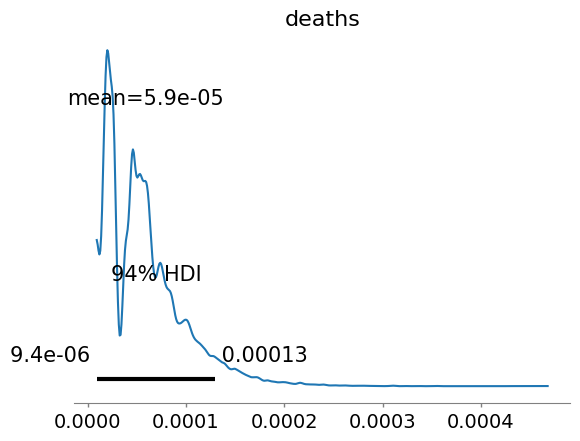

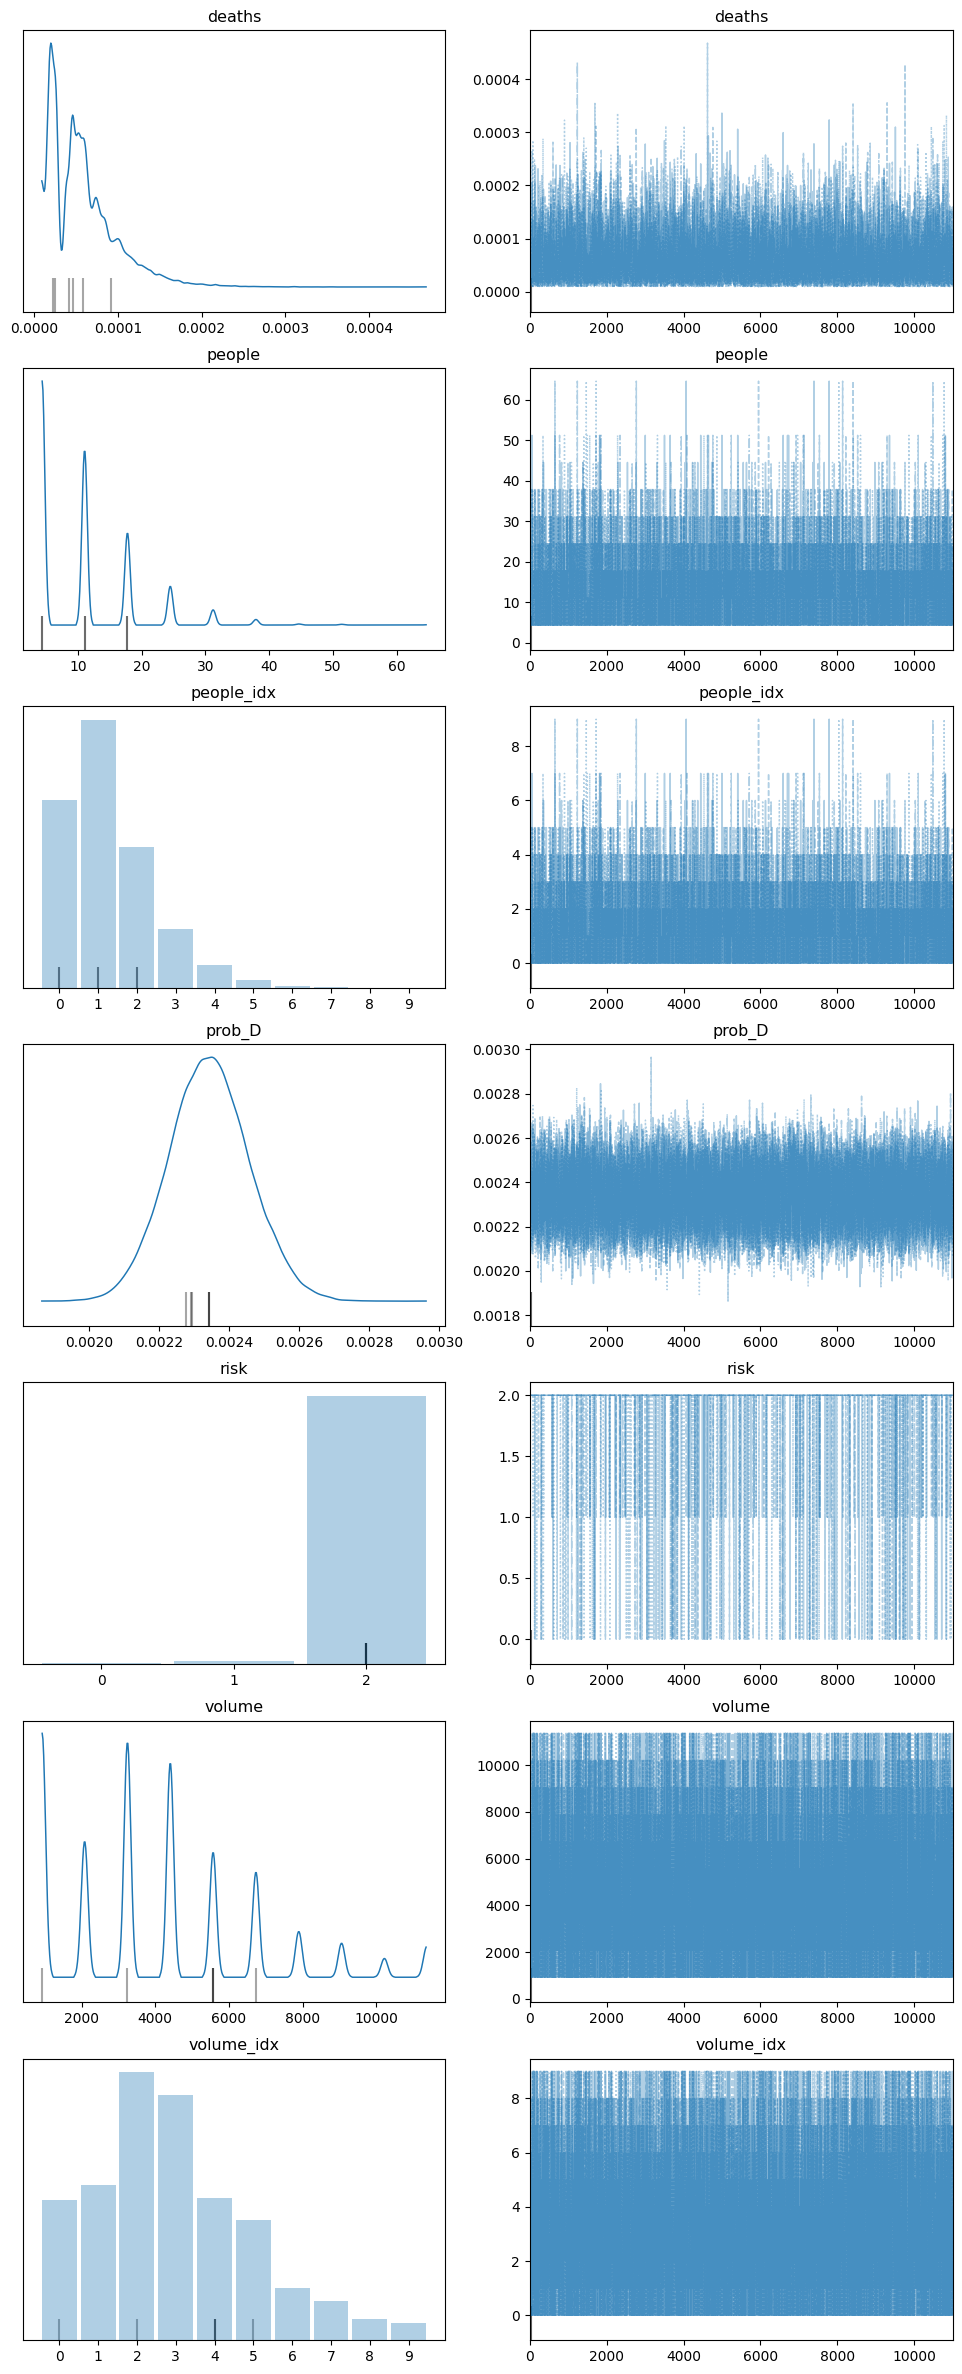

In [7]:
start = time.perf_counter()

with pm.Model() as model:
    # Add uncertainties to the key inputs
    # For number of people, a uniform distribution around the observed value
    # people = pm.Uniform("people", lower=max(0, idx_people - 5), upper=idx_people + 5)
    # Sample category index for number of people
    bin_midpoints_tensor = pt.as_tensor_variable(occupants_dist['bin_midpoint'].values)
    people_idx = pm.Categorical("people_idx", 
                               p=occupants_dist.loc[:, 'probability'].values)
    people = pm.Deterministic("people", bin_midpoints_tensor[people_idx]) 
 
    # For the probability of death, add uncertainties to the Beta distribution parameters (to show uncertainties on the model)
    # a_D = pm.Normal("a_D", mu=413.5, sigma=0.5) 
    # b_D = pm.Normal("b_D", mu=176171.5, sigma=50)
    # prob_D = pm.Beta("prob_D", alpha=a_D, beta=b_D)
    prob_D = pm.Beta("prob_D", alpha=413.5, beta=176171.5)
    
    # For Building volume, add a normal distribution around the observed value
    # volume = pm.math.maximum(
    #     pm.Normal("volume", mu=idx_volume, sigma=50),
    #     200.0
    # )
    volume_midpoints_tensor = pt.as_tensor_variable(volume_dist['bin_midpoint'].values)
    volume_idx = pm.Categorical("volume_idx", 
                               p=volume_dist.loc[:, 'probability'].values)
    volume = pm.Deterministic("volume", volume_midpoints_tensor[volume_idx])

    # For activation risk, use transition matrix row corresponding to uncertainty in activation risk
    p_true = M[2]
    risk = pm.Categorical("risk", p=p_true)  # sample true risk
    
    # Get risk factors directly using switch
    alpha = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["alpha"],  # risk = 0
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["alpha"],  # risk = 1
            risk_factors["High Risk"]["alpha"]     # risk = 2
        )
    )
    
    beta = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["beta"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["beta"],
            risk_factors["High Risk"]["beta"]
        )
    )
    
    gamma = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["gamma"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["gamma"],
            risk_factors["High Risk"]["gamma"]
        )
    )
    
    # Calculate fire probability using the selected risk factors
    prob_fire = 2/np.pi * pm.math.arctan(
        1.0 * pm.math.exp(alpha) * 
        volume ** beta / 
        pm.math.exp(21 * gamma)
    )

    deaths = pm.Deterministic("deaths", people*prob_fire*prob_D)
    
    trace = pm.sample(10000)  # runs MCMC automatically

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

pm.plot_posterior(trace, var_names=["deaths"])
az.plot_trace(trace, combined=True, figsize=(12, 30))
az.summary(trace)

### Sensitivity analysis

#### Based on correlation analysis

Sensitivity (deaths vs volume): 0.39039300757796436
Sensitivity (deaths vs risk): -0.02454540394953966
Sensitivity (deaths vs people): 0.8972792097806916
Sensitivity (deaths vs prob_D): 0.08106719967513837


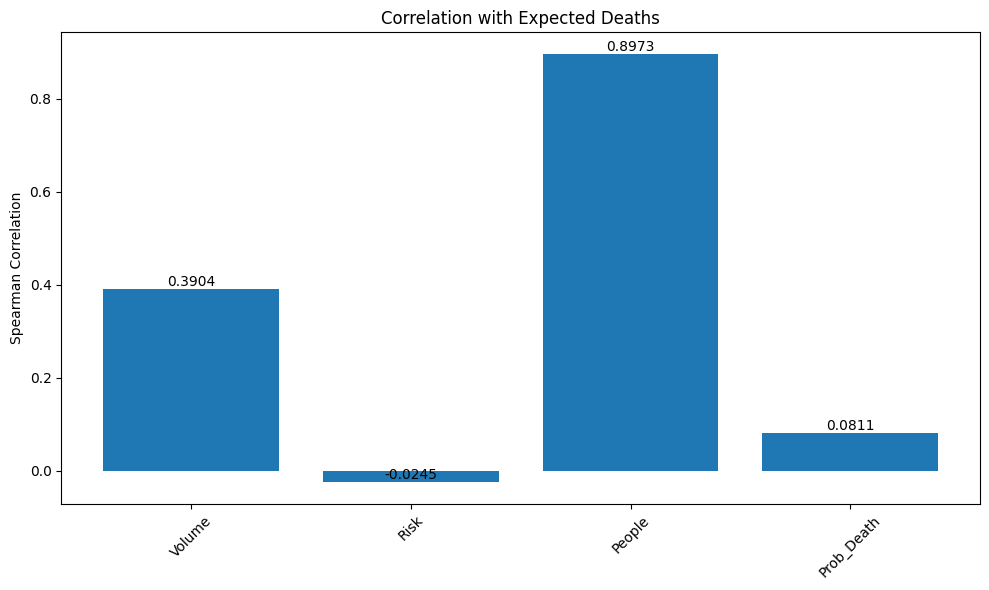

In [15]:
# Coorelation analysis
volume_samples = trace.posterior["volume"].values.flatten()
risk_samples = trace.posterior["risk"].values.flatten()
people_samples = trace.posterior["people"].values.flatten()
prob_D_samples = trace.posterior["prob_D"].values.flatten()
deaths_samples = trace.posterior["deaths"].values.flatten()

corr_v, _ = spearmanr(deaths_samples, volume_samples)
print("Sensitivity (deaths vs volume):", corr_v)
corr_r, _ = spearmanr(deaths_samples, risk_samples)
print("Sensitivity (deaths vs risk):", corr_r)
corr_p, _ = spearmanr(deaths_samples, people_samples)
print("Sensitivity (deaths vs people):", corr_p)
corr_D, _ = spearmanr(deaths_samples, prob_D_samples)
print("Sensitivity (deaths vs prob_D):", corr_D)

# Plot correlation values
plt.figure(figsize=(10, 6))
variables = ['Volume', 'Risk', 'People', 'Prob_Death']
corr_values = [corr_v, corr_r, corr_p, corr_D]

bars = plt.bar(variables, corr_values)
plt.title('Correlation with Expected Deaths')
plt.ylabel('Spearman Correlation')
plt.xticks(rotation=45)
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Based on mutual information analysis


Mutual Information Analysis:
MI(deaths, volume): 0.567452
MI(deaths, risk): 0.003671
MI(deaths, people): 0.870193
MI(deaths, prob_D): 0.062654


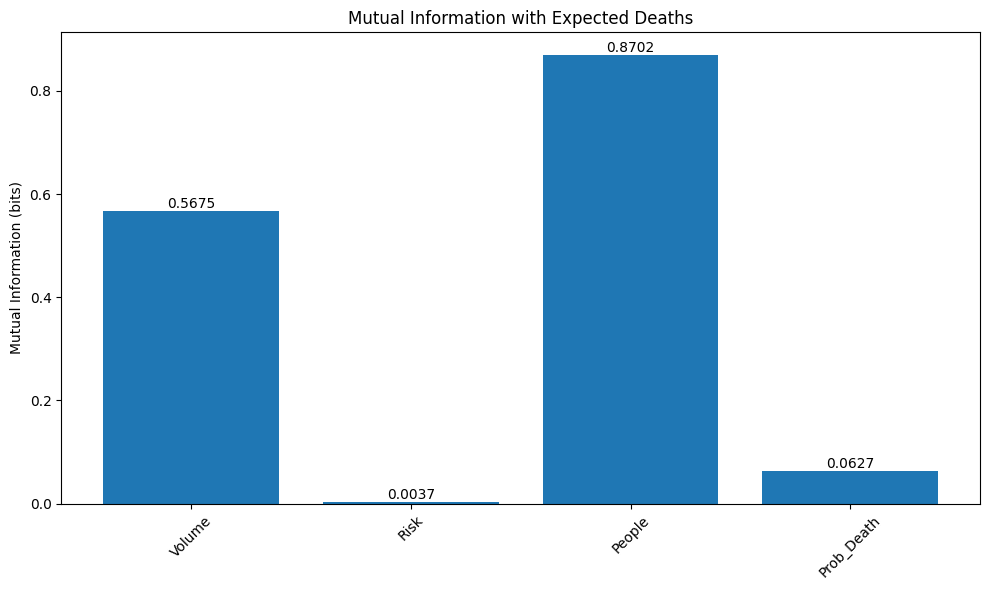

In [18]:
#-- Mutual Information Analysis ----

# Get samples from trace
volume_samples = trace.posterior["volume"].values.flatten()
risk_samples = trace.posterior["risk"].values.flatten()
people_samples = trace.posterior["people"].values.flatten()
prob_D_samples = trace.posterior["prob_D"].values.flatten()
deaths_samples = trace.posterior["deaths"].values.flatten()

# Function to calculate MI for continuous variables
def calc_mi_continuous(x, y, bins=50):
    # Discretize continuous variables using bins
    x_bins = np.histogram_bin_edges(x, bins=bins)
    y_bins = np.histogram_bin_edges(y, bins=bins)
    
    x_discrete = np.digitize(x, x_bins)
    y_discrete = np.digitize(y, y_bins)
    
    return mutual_info_score(x_discrete, y_discrete)

# Calculate MI for each input variable
mi_volume = calc_mi_continuous(volume_samples, deaths_samples)
mi_risk = mutual_info_score(risk_samples, np.digitize(deaths_samples, 
                          np.histogram_bin_edges(deaths_samples, bins=50)))
mi_people = calc_mi_continuous(people_samples, deaths_samples)
mi_prob_D = calc_mi_continuous(prob_D_samples, deaths_samples)

# Print results
print("\nMutual Information Analysis:")
print(f"MI(deaths, volume): {mi_volume:.6f}")
print(f"MI(deaths, risk): {mi_risk:.6f}")
print(f"MI(deaths, people): {mi_people:.6f}")
print(f"MI(deaths, prob_D): {mi_prob_D:.6f}")

# Plot MI values
plt.figure(figsize=(10, 6))
variables = ['Volume', 'Risk', 'People', 'Prob_Death']
mi_values = [mi_volume, mi_risk, mi_people, mi_prob_D]

bars = plt.bar(variables, mi_values)
plt.title('Mutual Information with Expected Deaths')
plt.ylabel('Mutual Information (bits)')
plt.xticks(rotation=45)
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()